Sentiment Classification of Tweets using BERT

In [1]:
# Imports
# General utils
import pandas as pd
import seaborn as sns

# Text processing libraries
import re
import contractions
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Model selection and pipeline utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

Read Data

In [2]:
reviews = pd.read_csv('./dataset/raw/reviews.csv')
data_in = reviews.copy()
data_in = data_in.drop_duplicates(subset="Review")
data_in.drop(["Time_submitted", "Total_thumbsup", "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data = data_in

data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


Code sentiments
* Ratings 1,2,3 as negative
* Ratings 4 & 5 as positive

In [3]:
## Code sentiment from rating (1 or 2 or 3 == bad, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2 or rating == 3:
        return "negative"
    if rating == 4 or rating == 5:
        return "positive"

data["Sentiment"] = data["Rating"].apply(get_sentiment)

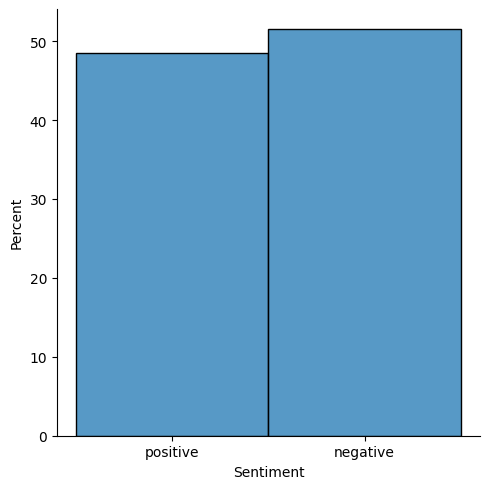

In [4]:
## Plot sentiment distribution
ax = sns.displot(data=data, x='Sentiment', stat='percent');

Define Stopwords
Use BLTK stopwords and need to keep NOT

In [5]:
stop_words = set(stopwords.words("english"))
stop_words.remove("not")

Translate emojis to text
U se following function to translate emojis to text. Will need the function later to include in prediction pipeline so that the data is transformed in the same way

In [6]:
# Function to clean the text data
def clean_text(textdata):
    textdata = textdata.lower()
    textdata = re.sub(r"@[A-Za-z0-9]+", "", textdata)  # Remove @mentions
    textdata = re.sub(r"#", "", textdata)  # Remove the '#' symbol
    textdata = re.sub(r"https?://[A-Za-z0-9./]+", "", textdata)  # Remove hyperlinks
    textdata = re.sub(r"[^a-zA-Z0-9\s]", "", textdata)  # Remove special characters and numbers
    textdata = re.sub(r"\s+", " ", textdata).strip()  # Remove extra spaces
    textdata = contractions.fix(textdata)  # Expand contractions
    textdata = emoji.demojize((textdata)) # Convert emojis to text
    textdata = textdata.replace('_', ' ') # Replace underscores with spaces
    return textdata

# test example to clean the text
print(clean_text("'RT @alexoceanblvd: Taylor Swift’s impact shines like a beacon, inspiring millions with her authentic storytelling and fearless evolution. 🌟✨ #Swiftie #TaylorSwift #Fearless'"))

print(clean_text('RT @TheSwiftSociety: 🏆| "Fearless TV" by Taylor Swift surpassed 4.8 BILLION Spotify Streams! https://t.co/9ACwhrgRx5'))

rt taylor swifts impact shines like a beacon inspiring millions with her authentic storytelling and fearless evolution swiftie taylorswift fearless
rt fearless tv by taylor swift surpassed 48 billion spotify streams


In [7]:
# Apply to all data
data["Review"] = data["Review"].apply(clean_text)
print(data.head())

                                              Review  Rating  Length Sentiment
0  great music service the audio is high quality ...       5      21  positive
1  please ignore previous negative rating this ap...       5      15  positive
2  this popup get the best spotify experience on ...       4      19  positive
3    really buggy and terrible to use as of recently       1       9  negative
4  dear spotify why do i get songs that i did not...       1      21  negative


Create features and target and split into training and test set

In [8]:
# Tokenize the data
tokenizer = RegexpTokenizer(r"\w+")

tokens = data["Review"].apply(tokenizer.tokenize)

tokens.sample(10)

8517     [the, best, 1000, percent, you, can, find, any...
52376     [very, easy, to, find, songs, and, to, download]
8229                     [nice, app, to, listen, a, music]
23597    [seriously, considering, ending, subscription,...
51943    [my, experience, on, spotify, has, been, amazi...
43856    [i, cannot, load, the, payment, page, it, keep...
33219    [app, is, good, overall, but, the, play, bar, ...
24196    [gone, downhill, since, update, at, least, can...
58179    [for, some, reason, spotify, registered, me, a...
35739    [i, cannot, seem, to, delete, strange, albums,...
Name: Review, dtype: object

In [9]:
# Join token with data
data["tokens"] = tokens
data.head()

,Review,Rating,Length,Sentiment,tokens
0,great music service the audio is high quality ...,5,21,positive,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating this ap...,5,15,positive,"[please, ignore, previous, negative, rating, t..."
2,this popup get the best spotify experience on ...,4,19,positive,"[this, popup, get, the, best, spotify, experie..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i did not...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ..."


In [10]:
X, y = data["Review"], data["Sentiment"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Shape of X_train and y_train: ", X_train.shape, y_train.shape)
print("Shape of X_test and y_test: ", X_test.shape, y_test.shape)
print(X_train.head())

Shape of X_train and y_train:  (42942,) (42942,)
Shape of X_test and y_test:  (18404,) (18404,)
22375    experience has been awful lately the fwdback 1...
6928                               good platform i love it
43746    gave it 5 stars a long time ago and updating m...
37052    what has happened to this app that was previou...
45807    keeps downloading old episodes of global news ...
Name: Review, dtype: object


In [12]:
## Encode labels in sklearn style
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [13]:
# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Pipeline

Train a ML model
Choose a ML model e.g. LogisticRegression and train it on vectorized data

In [14]:
# Logistic regresison
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

# Train model
log_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [15]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier()

rf1.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [16]:
print("Random forest classifier accuracy on TF-IDF vector", rf1.score(X_test_tfidf, y_test))
print("Logistic regression accuracy on TF-IDF vector", log_model.score(X_test_tfidf, y_test))

Random forest classifier accuracy on TF-IDF vector 0.8429145837861335
Logistic regression accuracy on TF-IDF vector 0.8678548141708324


Save the trained model
Save the model and the vectorizer for later use in api

In [25]:
import pickle

# Save the model
with open("models/sentiment_analysis_rf1_model.pkl", "wb") as model_file:
    pickle.dump(rf1, model_file)

with open("models/sentiment_analysis_log_model.pkl", "wb") as model_file:
    pickle.dump(log_model, model_file)

# Save the vectorizer
with open("models/tfidf_vectorizer.pkl", "wb") as vectorizer_file:
    pickle.dump(tfidf_vectorizer, vectorizer_file)

Load the model for prediction
Useful to use in api

In [26]:
# Load model
with open("models/sentiment_analysis_rf1_model.pkl", "rb") as model_file:
    loaded_rf1_model = pickle.load(model_file)
    
with open("models/sentiment_analysis_log_model.pkl", "rb") as model_file:
    loaded_log_model = pickle.load(model_file)
    
# Load vectorizer
with open("models/tfidf_vectorizer.pkl", "rb") as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)

In [27]:
# Example review to predict
example_review = 'RT @CounsellingSam: All our bills go up today.\nThe Cost Of Living Crisis is getting worse.\nLabour is doing nothing about its…'
example_review_cleaned = clean_text(example_review)
print(example_review_cleaned)
example_review_vectorized = loaded_vectorizer.transform([example_review_cleaned])
print(example_review_vectorized.shape)

rt all our bills go up today the cost of living crisis is getting worse labour is doing nothing about its
(1, 5000)


In [28]:
example_prediction = loaded_rf1_model.predict(example_review_vectorized)
# print("Predicted sentiment for the example review:", label_encoder.inverse_transform(example_prediction)[0])
print("Prediction with Random forest classifier:", example_prediction)

Prediction with Random forest classifier: [0]


In [29]:
example_prediction = loaded_log_model.predict(example_review_vectorized)
# print("Predicted sentiment for the example review:", label_encoder.inverse_transform(example_prediction)[0])
print("Prediction with logistic regression:", example_prediction)

Prediction with logistic regression: [0]


In [30]:
example_review = 'I love that Multo by Cup of Joe is wired like Fortnight by Taylor Swift'
example_review_cleaned = clean_text(example_review)
print(example_review_cleaned)
example_review_vectorized = loaded_vectorizer.transform([example_review_cleaned])
print(example_review_vectorized.shape)

i love that multo by cup of joe is wired like fortnight by taylor swift
(1, 5000)


In [31]:
example_prediction = loaded_rf1_model.predict(example_review_vectorized)
# print("Predicted sentiment for the example review:", label_encoder.inverse_transform(example_prediction)[0])
print("Prediction with random forest classifier:", example_prediction)

Prediction with random forest classifier: [1]


In [32]:
example_prediction = loaded_log_model.predict(example_review_vectorized)
# print("Predicted sentiment for the example review:", label_encoder.inverse_transform(example_prediction)[0])
print("Prediction with logistic regression:", example_prediction)

Prediction with logistic regression: [1]
